INFO:config.spark_config:Using Python executable: /Users/ali/Documents/Projects/micap/.venv2/bin/python
INFO:config.spark_config:Creating Spark session with driver memory: 12g
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/25 05:59:35 WARN Utils: Your hostname, Alis-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.8.177 instead (on interface en0)
25/05/25 05:59:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 05:59:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/25 05:59:36 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS i

Spark UI: http://localhost:4040


Total records: 40
root
 |-- tweet_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- text_processed: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emoji_sentiment: integer (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- processed_length: integer (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- tokens_lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- exclamation_count: integer (nullable = true)
 |-- question_count: integer (nullable = true)
 |-- uppercase_ratio: double (nullable = true)
 |-- punctuation_density: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double 

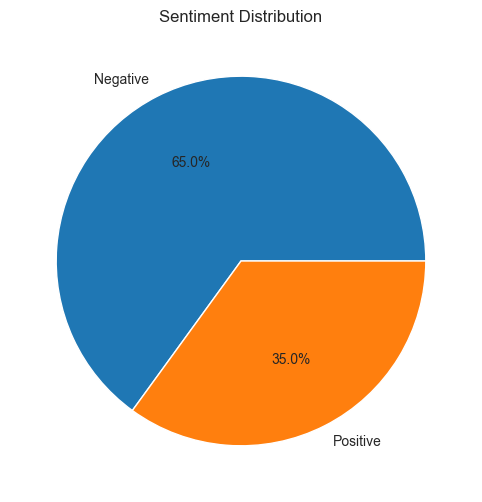

25/05/25 05:59:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,text_length,token_count,vader_compound,emoji_sentiment,exclamation_count
0,count,40,40,40,40,40
1,mean,83.775,8.975,0.2819525,0.0,0.7
2,stddev,36.09921335885597,3.8329709973683164,0.5617009223309464,0.0,1.3435505964154106
3,min,27,3,-0.911,0,0
4,max,143,18,0.9256,0,6


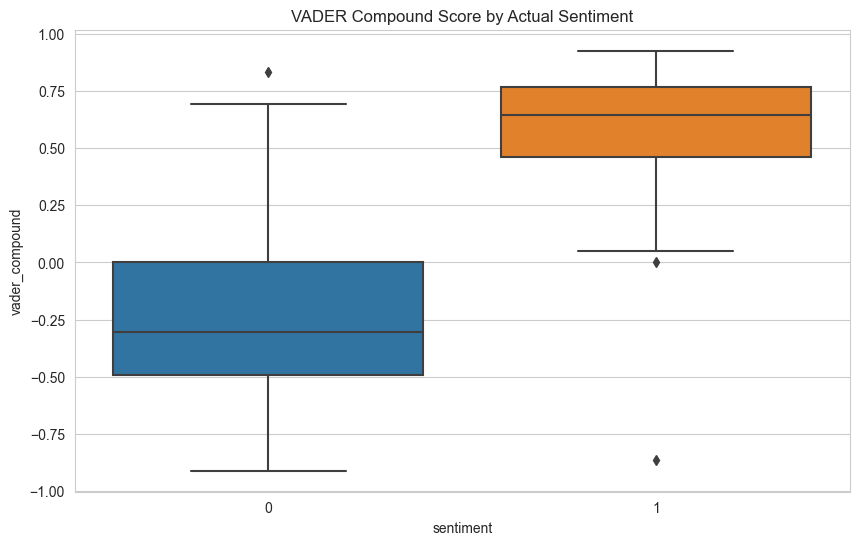

/Users/ali/Documents/Projects/micap/.venv2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ali/Documents/Projects/micap/.venv2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ali/Documents/Projects/micap/.venv2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ali/Documents/

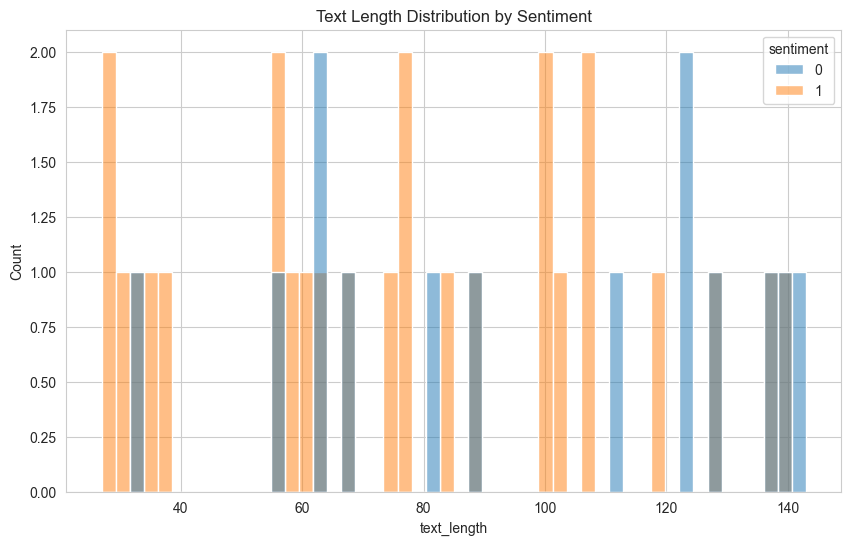

Sample positive tweets with high VADER scores:
+-----------------------------------------------------------------------------------------------------------------------------------------+--------------+---------------+
|text                                                                                                                                     |vader_compound|emoji_sentiment|
+-----------------------------------------------------------------------------------------------------------------------------------------+--------------+---------------+
|Jquery is my new best friend.                                                                                                            |0.8126        |0              |
|@accannis @edog1203 Great Stanford course. Thanks for making it available to the public! Really helpful and informative for starting off!|0.8928        |0              |
|AHH YES LOL IMA TELL MY HUBBY TO GO GET ME SUM MCDONALDS =]                                      

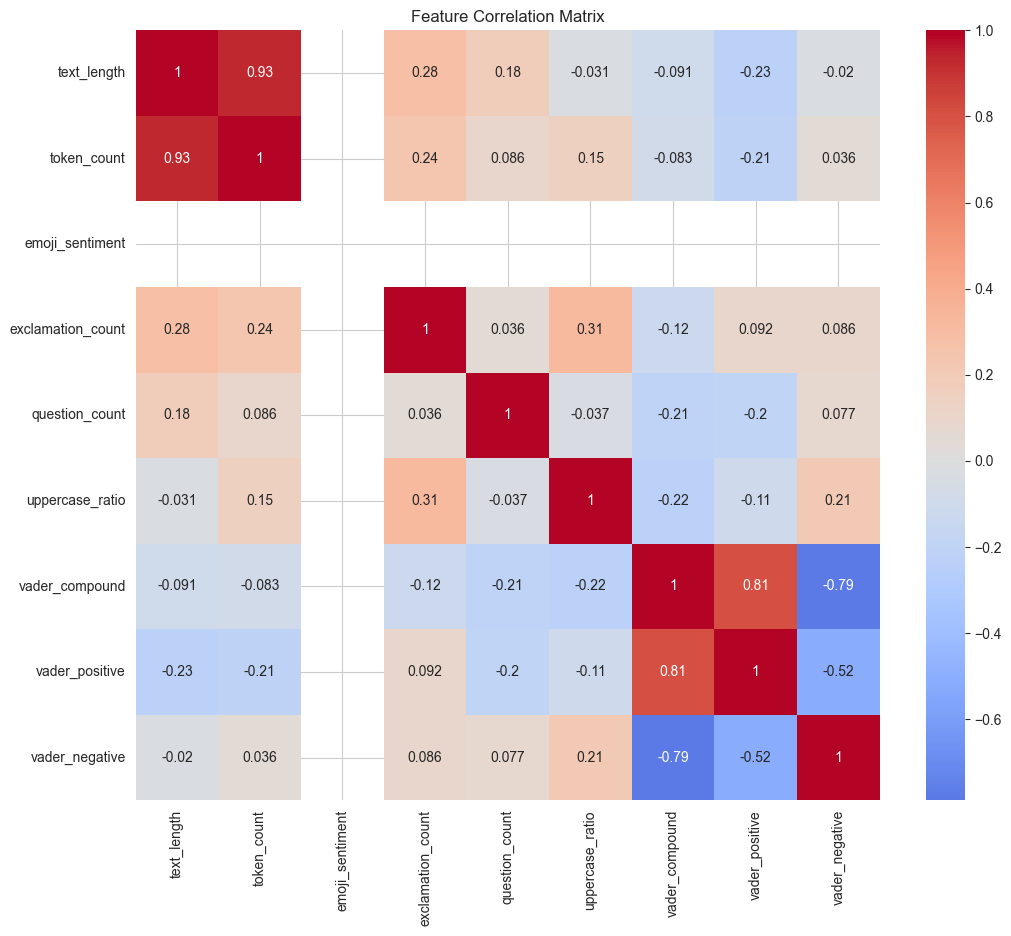

Data Processing Performance:
- Total partitions: 1
- Spark UI for detailed metrics: http://localhost:4040


In [1]:
# Cell 1: Setup and Imports
"""
Phase 1 Validation Notebook
Test and validate all Phase 1 components
"""
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config.spark_config import create_spark_session

# Cell 2: Initialize Spark
spark = create_spark_session("Phase1_Validation")
print(f"Spark UI: http://localhost:4040")

# Cell 3: Load Processed Data
df = spark.read.parquet("../data/processed/pipeline_features")
print(f"Total records: {df.count()}")
df.printSchema()

# Cell 4: Sentiment Distribution
sentiment_dist = df.groupBy("sentiment").count().toPandas()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_dist['count'], labels=['Negative', 'Positive'], autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

# Cell 5: Feature Analysis
feature_stats = df.select(
    "text_length", "token_count", "vader_compound",
    "emoji_sentiment", "exclamation_count"
).describe().toPandas()
display(feature_stats)

# Cell 6: VADER vs Actual Sentiment
vader_analysis = df.select("sentiment", "vader_compound").toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='vader_compound', data=vader_analysis)
plt.title('VADER Compound Score by Actual Sentiment')
plt.show()

# Cell 7: Text Length Distribution
length_data = df.select("sentiment", "text_length").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=length_data, x='text_length', hue='sentiment', bins=50)
plt.title('Text Length Distribution by Sentiment')
plt.show()

# Cell 8: Sample Tweets Analysis
print("Sample positive tweets with high VADER scores:")
df.filter((df.sentiment == 1) & (df.vader_compound > 0.8)) \
  .select("text", "vader_compound", "emoji_sentiment") \
  .show(5, truncate=False)

print("\nSample negative tweets with low VADER scores:")
df.filter((df.sentiment == 0) & (df.vader_compound < -0.8)) \
  .select("text", "vader_compound", "emoji_sentiment") \
  .show(5, truncate=False)

# Cell 9: Feature Correlations
numeric_features = [
    "text_length", "token_count", "emoji_sentiment",
    "exclamation_count", "question_count", "uppercase_ratio",
    "vader_compound", "vader_positive", "vader_negative"
]
corr_data = df.select(numeric_features).toPandas().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Cell 10: Performance Metrics
print("Data Processing Performance:")
print(f"- Total partitions: {df.rdd.getNumPartitions()}")
print(f"- Spark UI for detailed metrics: http://localhost:4040")